In [1]:
import torch

from reggae.utilities import save, load

from reggae.gp.variational.models import NonLinearLFM, ExponentialLFM
from reggae.gp.variational.trainer import Trainer
from reggae.data_loaders import load_humanp53
from reggae.plot.variational_plotters import Plotter
from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

torch.Size([22, 13])


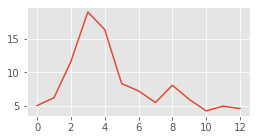

In [2]:
target_genes = [
    'KAZN','PMAIP1','PRKAB1','CSNK1G1','E2F7','SLC30A1',
    'PTP4A1','RAP2B','SUSD6','UBR5-AS1','RNF19B','AEN','ZNF79','XPC',
    'FAM212B','SESN2','DCP1B','MDM2','GADD45A','SESN1','CDKN1A','BTG2'
]
known_target_genes = [
    'CDKN1A', #p21
    'SESN1', #hPA26
    'DDB2',
    'TNFRSF10B',
    'BIK',
]

m_observed, f_observed, t = load_humanp53('../data/', target_genes)

replicate = 0

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)[replicate]

print(m_observed.shape)

num_genes = m_observed.shape[0]
num_tfs = 1
t_inducing = torch.linspace(f64(0), f64(1), 5, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(f64(0), f64(1), 13, dtype=torch.float64)
plt.figure(figsize=(4, 2))
plt.plot(m_observed[4])

In [3]:

def plot_genes(rtol=1e-4, atol=1e-6):
    t_predict = torch.linspace(f64(0), f64(1), 80)
    initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64

    # output_obs, _ = model(t_observed.view(-1), initial_value, rtol=rtol, atol=atol)
    # output_obs = torch.squeeze(output_obs).detach()
    # plt.plot(t_observed, output_obs[0])
    # plt.scatter(t_observed, m_observed[0][0])

    outputs, _ = model(t_predict.view(-1), initial_value, rtol=rtol, atol=atol, num_samples=1)

    outputs = torch.squeeze(outputs)
    print(outputs.shape)
    plt.figure(figsize=(5, 1.4 * num_genes))
    for i in range(num_genes):
        plt.subplot(num_genes, 1, 1+i)
        plt.plot(t_predict, torch.squeeze(outputs[i]).detach())
        plt.scatter(t_observed, m_observed[i])


In [4]:
model = NonLinearLFM(num_genes, num_tfs, t_inducing, t_observed, fixed_variance=None)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, (t_observed, m_observed))

# list(model.parameters())
print(t_observed.shape, m_observed.shape)

torch.Size([13]) torch.Size([22, 13])


C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = torch.tensor(t_inducing, requires_grad=False)


### Outputs prior to training:

torch.Size([22, 80])


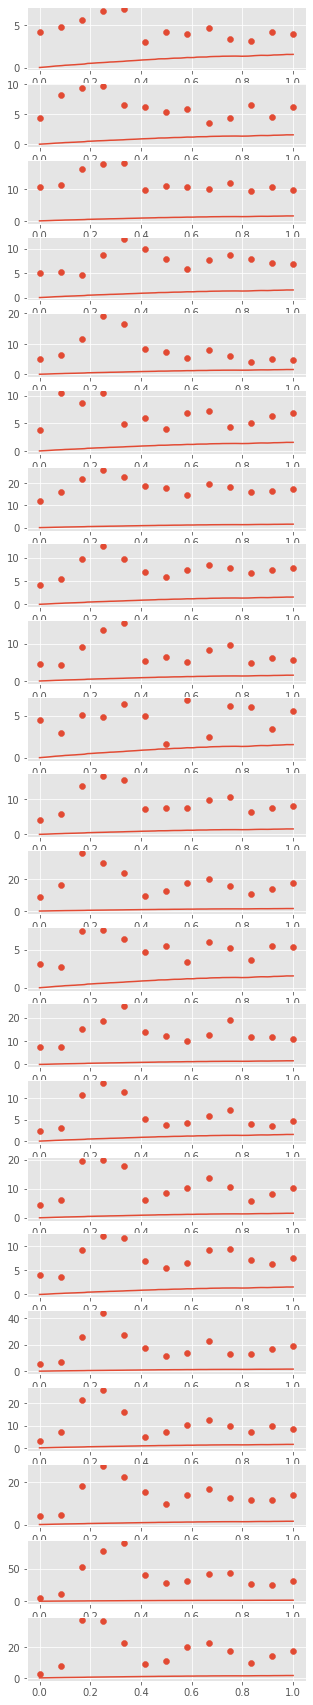

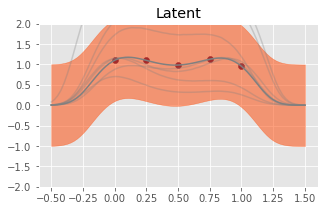

In [5]:
plotter = Plotter(model, m_df.index, t_inducing)
plot_genes(rtol=1e-3, atol=1e-4)
plotter.plot_tfs()

Epoch 1/40 - Loss: 23678.94 (23678.94 0.00) b: 0.40 d 0.80 s: 2.20 λ: 1.103
Epoch 2/40 - Loss: 20670.55 (20616.23 54.32) b: 0.60 d 0.60 s: 2.40 λ: 0.910
Epoch 3/40 - Loss: 18339.80 (18121.97 217.83) b: 0.79 d 0.40 s: 2.60 λ: 0.824
Epoch 4/40 - Loss: 15959.23 (15903.09 56.14) b: 0.98 d 0.20 s: 2.79 λ: 0.742
Epoch 5/40 - Loss: 14015.52 (13848.83 166.69) b: 1.14 d 0.05 s: 2.96 λ: 0.658
Epoch 6/40 - Loss: 12124.17 (12058.63 65.54) b: 1.27 d 0.02 s: 3.09 λ: 0.580
Epoch 7/40 - Loss: 10901.69 (10879.42 22.26) b: 1.35 d 0.08 s: 3.15 λ: 0.513
Epoch 8/40 - Loss: 9973.79 (9929.74 44.05) b: 1.39 d 0.18 s: 3.16 λ: 0.452
Epoch 9/40 - Loss: 8982.97 (8938.48 44.49) b: 1.40 d 0.31 s: 3.12 λ: 0.396
Epoch 10/40 - Loss: 8260.38 (8228.09 32.28) b: 1.39 d 0.45 s: 3.06 λ: 0.347
Epoch 11/40 - Loss: 7643.25 (7622.73 20.52) b: 1.37 d 0.61 s: 2.98 λ: 0.305
Epoch 12/40 - Loss: 6979.08 (6966.59 12.49) b: 1.33 d 0.77 s: 2.89 λ: 0.270
Epoch 13/40 - Loss: 6474.54 (6465.32 9.22) b: 1.29 d 0.93 s: 2.79 λ: 0.241
Epoch 1

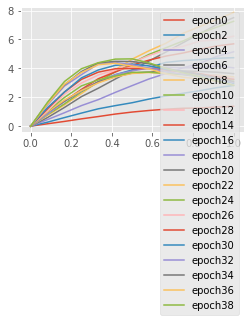

In [6]:
tol = 1e-3
# trainer = Trainer(optimizer)
output = trainer.train(40, rtol=tol, atol=tol/10, report_interval=1, plot_interval=2)

### Outputs after training

torch.Size([22, 80])


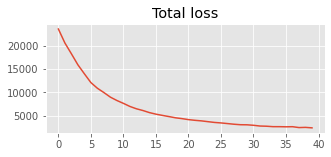

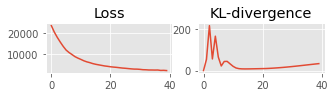

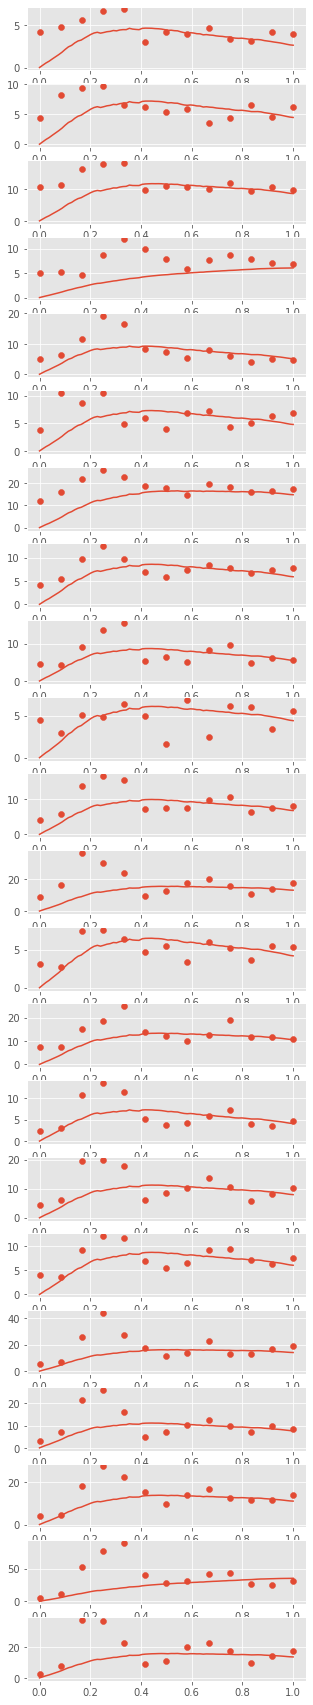

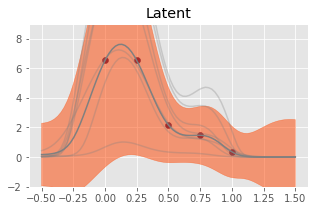

In [7]:
plotter = Plotter(model, m_df.index, t_inducing)

tol = 1e-3
plotter.plot_losses(trainer, last_x=100)
plot_genes(rtol=tol, atol=tol/10)
plotter.plot_tfs(ylim=(-2, 9))


In [9]:
save(model, 'nonlinear')

In [5]:
model = load('nonlinear', NonLinearLFM, num_genes, num_tfs, t_inducing, t_observed, fixed_variance=None)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, (t_observed, m_observed))

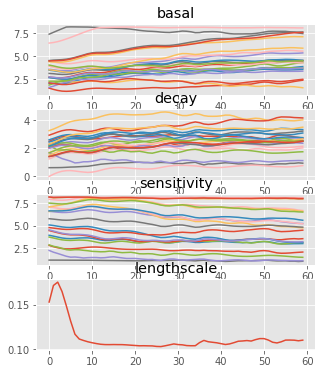

In [14]:
titles = ['basal', 'decay', 'sensitivity', 'lengthscale']
datas = [np.array(trainer.basalrates)[:,:,0],
         np.array(trainer.decayrates)[:,:,0],
         np.array(trainer.sensitivities)[:,:,0],
         np.array(trainer.lengthscales)]

plt.figure(figsize=(5, 6))
for i, (title, data) in enumerate(zip(titles, datas)):
    plt.subplot(411 + i)
    plt.title(title)
    # if data.ndim > 1:
    #     for j in range(data.shape[1]):

    plt.plot(data)

tensor([[1.4055e+01, 3.0223e+00, 1.2636e-01, 2.6475e-01, 1.3350e-01, 8.5441e+00,
         3.9458e-01, 6.1930e-02, 1.6052e+00, 6.8549e-02, 2.0691e-01, 4.7785e-01,
         3.6926e-01],
        [1.4226e+01, 1.2318e+01, 1.8895e+00, 2.2054e-01, 8.4948e+00, 2.3989e+00,
         8.3612e-01, 7.8189e-01, 4.3191e-01, 1.1947e-01, 4.6284e+00, 7.5372e-02,
         3.5839e+00],
        [1.5905e+01, 1.0259e+01, 6.0007e+00, 6.1867e-01, 6.3975e-01, 1.2200e+01,
         6.3516e+00, 6.0201e-01, 7.3971e-01, 8.1210e+00, 7.1035e-01, 1.0240e+00,
         5.5080e-01],
        [1.4988e+01, 1.0607e+01, 1.8253e-01, 1.0848e+01, 1.3398e+01, 9.8518e+00,
         5.4334e-01, 1.7186e+00, 5.5561e-02, 8.1924e-01, 1.1952e-01, 2.8779e+00,
         3.9859e+00],
        [1.4919e+01, 5.7731e-01, 3.7599e-01, 1.2584e+01, 9.3437e+00, 6.5696e+00,
         1.3856e-01, 1.1859e-01, 1.1141e+01, 3.7648e+00, 3.1153e-01, 9.4601e-02,
         5.5425e-02],
        [1.3339e+01, 1.3967e+01, 2.5932e-01, 4.0127e-01, 1.3553e+01, 9.6931e+00,